# Market Basket Analysis Using Association Rules and PySpark
By :
*   Jumana Lightwala (c0892358)
*   Bibek Shiwakoti (c0898100)
*   Prajina Rajkarnikar (c0906293)
*   Ronak Shah (C0891297)
*   Umesh Khatiwada (C0893975)


In [26]:
# Set the environment variable SPARK_LOCAL_HOSTNAME to localhost
%env SPARK_LOCAL_HOSTNAME=localhost
# !pip install findspark
# !pip install pyspark

# Importing necessary libraries
import findspark
findspark.init

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.feature import StringIndexer
from pyspark.sql import SQLContext, SparkSession
from pyspark.sql.functions import *
import numpy as np
from pyspark.ml.fpm import FPGrowth



env: SPARK_LOCAL_HOSTNAME=localhost


In [27]:
# Create a Spark session
spark = SparkSession.builder.config("spark.driver.host", "localhost").getOrCreate()
spark = SparkSession.Builder().appName('Project').getOrCreate()
sqlCtx = SQLContext(spark)


## Data Preparation and Cleaning:

The dataset was loaded into a Spark DataFrame and underwent preprocessing steps such as filling missing values, removing rows with zero or negative quantities, and creating new columns for total price calculation.
Outlier detection using the IQR method was conducted, resulting in the identification and visualization of outliers using box plots.
Outliers were then handled using flooring and capping techniques to ensure the integrity of the data.

In [28]:
# Read the CSV file into a Spark DataFrame
df_market = spark.read.csv('/Market_Basket_Analysis_data.csv', header='true', inferSchema='true', sep=';')


In [29]:
df_market.summary().show()

+-------+-----------------+--------------------+------------------+----------------+------------------+------------------+-----------+
|summary|           BillNo|            Itemname|          Quantity|            Date|             Price|        CustomerID|    Country|
+-------+-----------------+--------------------+------------------+----------------+------------------+------------------+-----------+
|  count|           522064|              520609|            522064|          522064|            522064|            388023|     522064|
|   mean|559950.7852856276|                NULL|10.090435272303779|            NULL|15.576812289966394|15316.931710233672|       NULL|
| stddev|13452.75089984722|                NULL|161.11052518229152|            NULL| 72.62169390055651| 1721.846964266427|       NULL|
|    min|           536365|"ASSORTED FLOWER ...|             -9600|01.02.2011 08:23|         -11062,06|             12346|  Australia|
|    25%|         547888.0|                NULL|       

In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
num_records = df_market.count()
print('Number of records: ', num_records)

Number of records:  522064


In [32]:
# Fill missing values in the CustomerID column with 99999
df_market = df_market.fillna(99999, subset='CustomerID')

In [33]:
# Remove rows where Quantity is less than or equal to 0
df_market = df_market.filter(df_market.Quantity > 0)

In [34]:
# Drop rows with null values
df_market = df_market.dropna()

In [35]:
# Create a Total_Price column by multiplying Price and Quantity, and clean other fields
df_market = df_market.withColumn('Price', regexp_replace('Price', ',', '.'))
df_market = df_market.withColumn('Total_Price', round(df_market.Price * df_market.Quantity, 2))
df_market = df_market.withColumn('Hour', split('Date', ' ')[1])
df_market = df_market.withColumn('Date', split('Date', ' ')[0])
df_market = df_market.withColumn('Date', concat_ws('-', split('Date', '\\.')[2], split('Date', '\\.')[1], split('Date', '\\.')[0]))
df_market = df_market.withColumn('Date', to_date('Date'))


In [36]:
# Add a column for the product of Quantity and Price
df_market_price = df_market.withColumn("Quantity_times_Price", col("Quantity") * col("Price"))


In [37]:
# Round the Total_Price and Quantity_times_Price columns to 2 decimal places
df_market_price = df_market_price.withColumn("Total_Price_rounded", round(col("Total_Price"), 2))
df_market_price = df_market_price.withColumn("Quantity_times_Price_rounded", round(col("Quantity_times_Price"), 2))


In [38]:
df_market_price = df_market_price.withColumn("Price_times_Quantity_equals_Total_Price", col("Total_Price_rounded") == col("Quantity_times_Price_rounded"))


In [39]:
df_market_price = df_market_price.select("BillNo", "Quantity", "Price", "Total_Price_rounded", "Quantity_times_Price_rounded", "Price_times_Quantity_equals_Total_Price")


In [40]:
df_market_price.show()

+------+--------+-----+-------------------+----------------------------+---------------------------------------+
|BillNo|Quantity|Price|Total_Price_rounded|Quantity_times_Price_rounded|Price_times_Quantity_equals_Total_Price|
+------+--------+-----+-------------------+----------------------------+---------------------------------------+
|536365|       6| 2.55|               15.3|                        15.3|                                   true|
|536365|       6| 3.39|              20.34|                       20.34|                                   true|
|536365|       8| 2.75|               22.0|                        22.0|                                   true|
|536365|       6| 3.39|              20.34|                       20.34|                                   true|
|536365|       6| 3.39|              20.34|                       20.34|                                   true|
|536365|       2| 7.65|               15.3|                        15.3|                        

In [41]:
count = df_market_price.count()
print("Number of rows:", count)

Number of rows: 520136


In [42]:
# Outlier Detection using IQR method
quantiles = df_market.approxQuantile('Total_Price', [0.25, 0.75], 0.05)
q1 = quantiles[0]
q3 = quantiles[1]

iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

outliers = df_market.filter((df_market.Total_Price < lower_bound) | (df_market.Total_Price > upper_bound))

print("Total outliers ", outliers.count())


Total outliers  43264


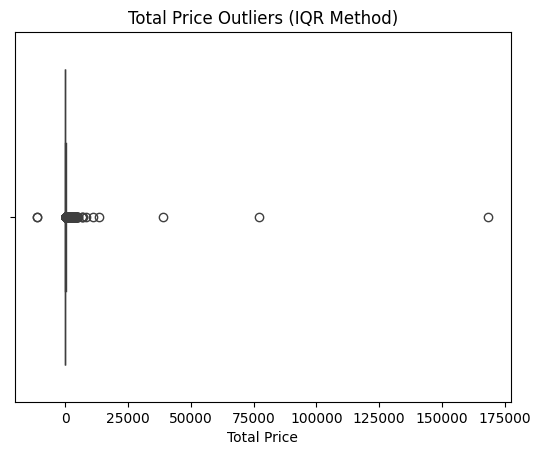

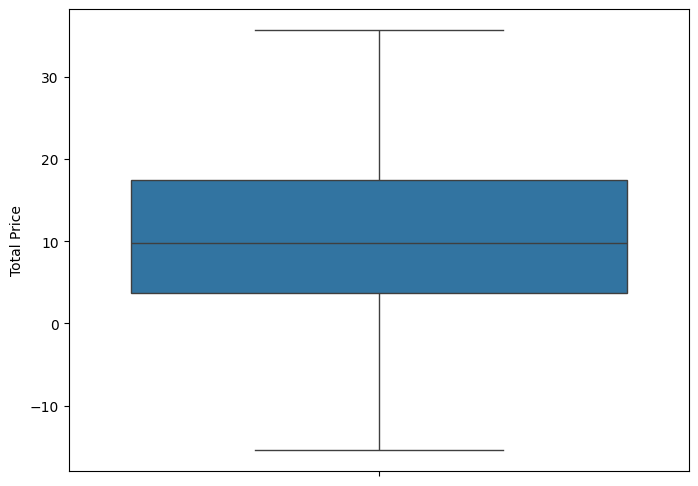

In [43]:
# Visualize outliers using a box plot
import matplotlib.pyplot as plt
import seaborn as sns

outliers_iqr_pd = outliers.select('Total_Price').toPandas()

sns.boxplot(x=outliers_iqr_pd['Total_Price'], orient='h')
plt.title('Total Price Outliers (IQR Method)')
plt.xlabel('Total Price')
plt.show()

# Floor and Cap outliers
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

df_market = df_market.withColumn('Total_Price_Floor_Cap', when(df_market.Total_Price < lower_bound, lower_bound).when(df_market.Total_Price > upper_bound, upper_bound).otherwise(df_market.Total_Price))

# Visualize Total_Price after outlier removal
total_price_pd = df_market.select('Total_Price_Floor_Cap').toPandas()

plt.figure(figsize=(8, 6))
sns.boxplot(data=total_price_pd, y='Total_Price_Floor_Cap')
plt.ylabel('Total Price')
plt.show()

Observation : In the above code we have detected 42211 outliers in our dataset using IQR method. In order to eliminate detected outliers with upper and lowe cap values we decided to use flooring and capping method.

## Data Analysis:

The data was analyzed to find insights such as the top-selling products in each country and the total revenue earned by each country.
Visualizations were generated to illustrate total revenue by country and the distribution of expenses per customer.

In [44]:
# Group the data by country and item name, and compute the total quantity and total price of each item in each country
df_market.createOrReplaceTempView("df")
itemname_by_country = sqlCtx.sql("""SELECT Country, Itemname, SUM(Quantity) as Quantity, SUM(Total_Price) as Total_Price FROM df GROUP BY Country, Itemname""")
itemname_by_country.createOrReplaceTempView("itemname_by_country")

In [45]:
# Find the top-selling product (based on quantity) in each country
top_product_country = sqlCtx.sql("""SELECT Country, Itemname, Quantity FROM
    (SELECT Country, Itemname, Quantity, MAX(Quantity) OVER(PARTITION BY Country) AS Max_Quant FROM itemname_by_country)
    WHERE Quantity=MAX_Quant
    """)
# Print the top-selling products in each country
print("Best sellers by country")
top_product_country.orderBy('Quantity', ascending=False).show(40, truncate=False)

Best sellers by country
+--------------------+-----------------------------------+--------+
|Country             |Itemname                           |Quantity|
+--------------------+-----------------------------------+--------+
|United Kingdom      |PAPER CRAFT , LITTLE BIRDIE        |80995   |
|Netherlands         |RABBIT NIGHT LIGHT                 |4801    |
|France              |RABBIT NIGHT LIGHT                 |4024    |
|Japan               |RABBIT NIGHT LIGHT                 |3408    |
|Australia           |MINI PAINT SET VINTAGE             |2952    |
|Sweden              |MINI PAINT SET VINTAGE             |2916    |
|Germany             |ROUND SNACK BOXES SET OF4 WOODLAND |1233    |
|Spain               |CHILDRENS CUTLERY POLKADOT PINK    |729     |
|Switzerland         |PLASTERS IN TIN WOODLAND ANIMALS   |639     |
|Norway              |SMALL FOLDING SCISSOR(POINTED EDGE)|576     |
|Belgium             |PACK OF 72 RETROSPOT CAKE CASES    |480     |
|Singapore           |CH

In [46]:
# Calculate the total revenue (Total_Price) earned by each country
tot_price_by_country = sqlCtx.sql("""SELECT Country, ROUND(SUM(Total_Price), 2) AS Total_Price FROM itemname_by_country GROUP BY Country""")
print("Total gain by country")
tot_price_by_country_pd = tot_price_by_country.orderBy('Total_Price', ascending=False).toPandas()
tot_price_by_country_pd.head(40)


Total gain by country


,Country,Total_Price
0,United Kingdom,9003097.96
1,Netherlands,285446.34
2,Germany,228867.14
3,France,209715.11
4,Australia,138521.31
5,Spain,61577.11
6,Switzerland,57089.90
7,Belgium,41196.34
8,Sweden,38378.33
9,Japan,37416.37


## Visualization


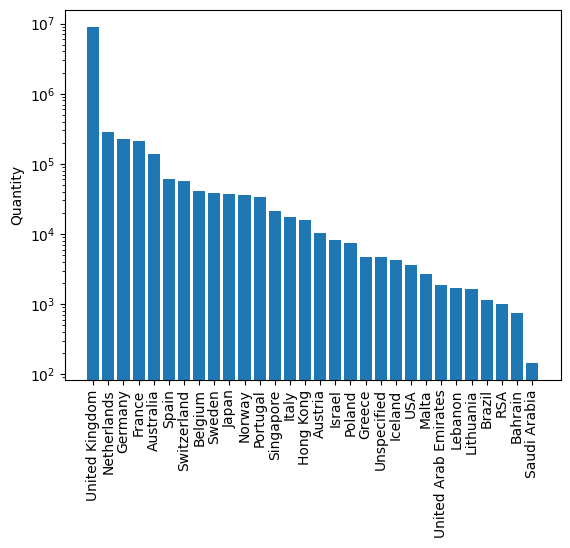

In [47]:
# Visualize total revenue by country
x = tot_price_by_country_pd['Country']
y = tot_price_by_country_pd['Total_Price']

plt.bar(x, y)
plt.yscale('log')
plt.ylabel('Quantity')
plt.xticks(rotation=90)
plt.show()

Observation: With a high level view the graph depicts to have a descending trend from highest revenue generated in United Kingdom to the least in Saudi Arabia.

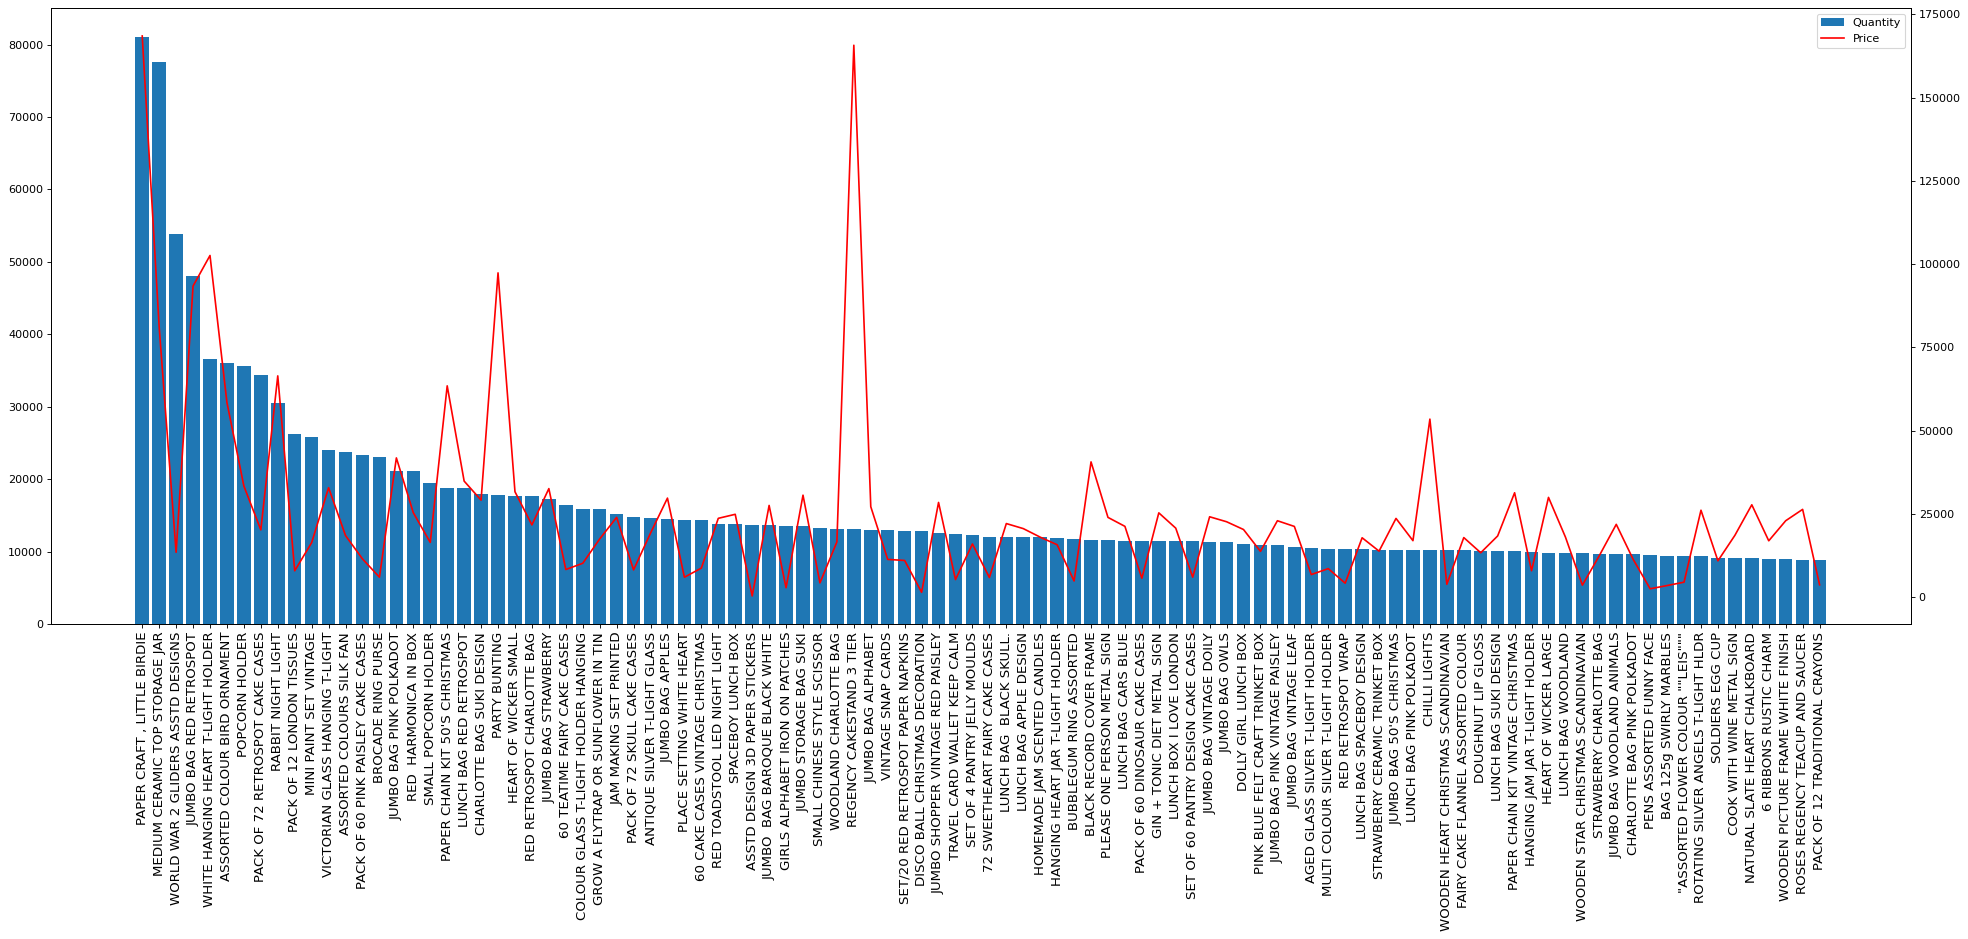

In [48]:
# Group items by quantity and total price
items_quantity = sqlCtx.sql("""SELECT Itemname, SUM(Quantity) as Quantity, SUM(Total_Price) as Total_Price FROM itemname_by_country GROUP BY Itemname""")
items_quantity_df = items_quantity.toPandas()

items_quantity_df = items_quantity_df.sort_values(by='Quantity', ascending=False)

ntop = 100

x = items_quantity_df['Itemname'][:ntop]
quant = items_quantity_df['Quantity'][:ntop]
price = items_quantity_df['Total_Price'][:ntop]
plt.figure(figsize=(30, 10), dpi=80)

ax1 = plt.subplot()
l1 = ax1.bar(x, quant, label='Quantity')
plt.xticks(rotation=90, fontsize=12)

ax2 = ax1.twinx()
l2, = ax2.plot(x, price, label='Price', color='r')
plt.legend([l1, l2], ["Quantity", "Price"])
plt.show()

Observation: From the given graph the bars represents Quantities of Items sold and the line represents Prices of items respectively. It can be depicted that the majority of represented items have equally low volume with respective prices except for a few items such as - PAPER CRAFT, LITTLE BIRDIE with high price, high quatity and REGENCY CAKESTAND 3 TIER with high price but low quatity.

<ipython-input-49-4be75e252537>:6: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.1`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.14.0.

  sns.kdeplot((np.log10(expense_per_customer_pd['Total_Price'][expense_per_customer_pd['Total_Price']>0])), bw=0.1, color='r')


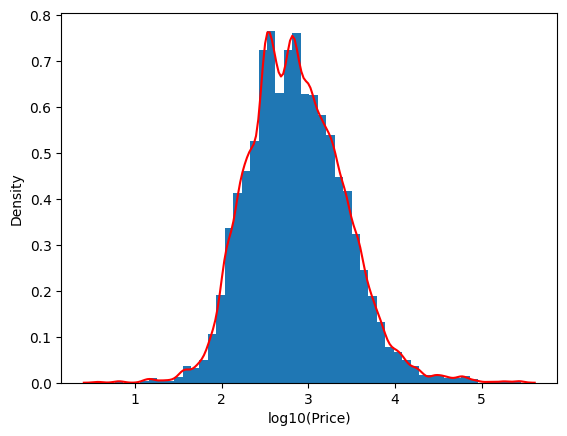

In [49]:
# Calculate and visualize the distribution of expenses per customer
expense_per_customer = sqlCtx.sql("""SELECT CustomerID, Country, SUM(Total_Price) as Total_Price FROM df WHERE CustomerID <> 99999 GROUP BY CustomerID, Country""")
expense_per_customer_pd = expense_per_customer.toPandas()

plt.hist(np.log10(expense_per_customer_pd['Total_Price'][expense_per_customer_pd['Total_Price']>0]), bins=50, density=True)
sns.kdeplot((np.log10(expense_per_customer_pd['Total_Price'][expense_per_customer_pd['Total_Price']>0])), bw=0.1, color='r')
plt.xlabel('log10(Price)')
plt.show()

From the graph above, we can infer with 2 peeks in log scale the graph is symmetrical on both ends.

# Apriori Analysis
- The Apriori algorithm was applied to mine association rules for a subset of countries, with specified minimum support and confidence thresholds.
- Association rules were examined to determine the number of countries in which they are present and the mean and minimum lift values.
- Additionally, the Apriori algorithm was executed for the entire dataset to identify association rules with significant lift values.

In [50]:
# Apply StringIndexer to convert Itemname column from categorical string values to numerical indices
indexer = StringIndexer(inputCol="Itemname", outputCol="ItemnameIndex")
df_group = indexer.fit(df_market).transform(df_market)

# Group by BillNo and Country and create a vector of unique Itemname values for each combination
df_group = df_group[['Country', 'BillNo', 'Itemname']].distinct()
df_group = df_group.groupBy('BillNo', 'Country').agg(collect_list('Itemname').alias('Itemname_vec'))

# Perform Apriori algorithm for a subset of countries
minSupport=0.1
minConfidence=0.8
results = {}
countries = ['Belgium', 'Germany', 'Italy', 'Netherlands', 'Portugal', 'Norway', 'Spain', 'Sweden', 'Australia' ]

for country in countries:
    fpGrowth = FPGrowth(itemsCol="Itemname_vec", minSupport=minSupport, minConfidence=minConfidence)
    model = fpGrowth.fit(df_group.filter(df_group['Country']==country))
    results[country] = model.associationRules


In [51]:
# Combine results for multiple countries into a single DataFrame
country = countries[0]
apriori = results[country].withColumn('country', lit(country))

for country in countries[1:5]:
    df_temp = results[country].withColumn('country', lit(country))
    apriori =  apriori.union(df_temp)

# Calculate the number of countries in which a certain association rule is present, as well as the mean and minimum lift
apriori.createOrReplaceTempView("apriori")
rules = sqlCtx.sql("""SELECT antecedent, consequent, COUNT(DISTINCT country) as n_country , ROUND(AVG(lift), 3) as mean_lift, ROUND(MIN(lift), 3) as min_lift FROM apriori GROUP BY antecedent, consequent""")
rules.sort(col('n_country').desc(), col('mean_lift').desc()).show(30, truncate=False)

+-----------------------------------------------------------------------+-------------------------------------+---------+---------+--------+
|antecedent                                                             |consequent                           |n_country|mean_lift|min_lift|
+-----------------------------------------------------------------------+-------------------------------------+---------+---------+--------+
|[ROUND SNACK BOXES SET OF 4 FRUITS]                                    |[ROUND SNACK BOXES SET OF4 WOODLAND] |3        |2.954    |2.11    |
|[REGENCY CAKESTAND 3 TIER]                                             |[POSTAGE]                            |3        |1.292    |1.021   |
|[PLASTERS IN TIN CIRCUS PARADE]                                        |[PLASTERS IN TIN WOODLAND ANIMALS]   |2        |6.274    |6.214   |
|[ROUND SNACK BOXES SET OF 4 FRUITS, POSTAGE]                           |[ROUND SNACK BOXES SET OF4 WOODLAND] |2        |2.791    |2.211   |
|[ROUND SNACK

In [52]:
# Perform Apriori algorithm for the whole dataset
minSupport=0.02
minConfidence=0.4

fpGrowth = FPGrowth(itemsCol="Itemname_vec", minSupport=minSupport, minConfidence=minConfidence)
model = fpGrowth.fit(df_group)
results = model.associationRules


In [53]:
# Show the association rules ordered by lift
for column in ['confidence', 'lift', 'support']:
    results = results.withColumn(column, round(results[column], 3))

results.sort(col('lift').desc()).show(20, truncate=False)

+------------------------------------------------------------------+-----------------------------------+----------+------+-------+
|antecedent                                                        |consequent                         |confidence|lift  |support|
+------------------------------------------------------------------+-----------------------------------+----------+------+-------+
|[GREEN REGENCY TEACUP AND SAUCER, ROSES REGENCY TEACUP AND SAUCER]|[PINK REGENCY TEACUP AND SAUCER]   |0.705     |18.891|0.026  |
|[PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY TEACUP AND SAUCER] |[GREEN REGENCY TEACUP AND SAUCER]  |0.904     |18.288|0.026  |
|[PINK REGENCY TEACUP AND SAUCER]                                  |[GREEN REGENCY TEACUP AND SAUCER]  |0.822     |16.638|0.031  |
|[GREEN REGENCY TEACUP AND SAUCER]                                 |[PINK REGENCY TEACUP AND SAUCER]   |0.621     |16.638|0.031  |
|[PINK REGENCY TEACUP AND SAUCER, GREEN REGENCY TEACUP AND SAUCER] |[ROSES REGENCY 

# FP-Growth algorithm
- The FP-Growth algorithm was utilized to extract frequent itemsets and association rules from the dataset.
- Frequent itemsets mined using FP-Growth were displayed, showcasing the items frequently purchased together.
- Association rules derived from FP-Growth provided further insights into item associations and purchasing patterns.

In [54]:
# Import the FP-Growth class from PySpark MLlib
from pyspark.ml.fpm import FPGrowth

# Create an instance of the FP-Growth algorithm
fp_growth = FPGrowth(itemsCol="Itemname_vec", minSupport=0.02, minConfidence=0.04)

# Fit the FP-Growth model to the dataset
model_fpgrowth = fp_growth.fit(df_group)

# Extract the frequent itemsets from the model
frequent_itemsets = model_fpgrowth.freqItemsets

# Display the frequent itemsets
print("Frequent Itemsets Mined using FP-Growth Algorithm:")
frequent_itemsets.show(truncate=False)

# Extract the association rules from the model
association_rules_fpgrowth = model_fpgrowth.associationRules

# Display the association rules
print("Association Rules Mined using FP-Growth Algorithm:")
association_rules_fpgrowth.show(truncate=False)


Frequent Itemsets Mined using FP-Growth Algorithm:
+--------------------------------------------------------------+----+
|items                                                         |freq|
+--------------------------------------------------------------+----+
|[HAND WARMER BIRD DESIGN]                                     |552 |
|[RECIPE BOX RETROSPOT]                                        |450 |
|[ANTIQUE SILVER T-LIGHT GLASS]                                |681 |
|[JUMBO BAG VINTAGE CHRISTMAS]                                 |470 |
|[SINGLE HEART ZINC T-LIGHT HOLDER]                            |500 |
|[FLORAL FOLK STATIONERY SET]                                  |420 |
|[ZINC METAL HEART DECORATION]                                 |523 |
|[HOT WATER BOTTLE I AM SO POORLY]                             |642 |
|[SET OF 20 VINTAGE CHRISTMAS NAPKINS]                         |590 |
|[ENAMEL BREAD BIN CREAM]                                      |438 |
|[JUMBO BAG SCANDINAVIAN BLUE PAISLEY] 

# Comments:
- The preprocessing steps effectively cleaned the dataset, ensuring its suitability for subsequent analysis and modeling.
- Outlier detection and handling techniques were essential for maintaining data integrity and reliability.
- The analysis revealed valuable insights into customer purchasing behaviors, top-selling products, and revenue generation across different countries.
- Both the Apriori and FP-Growth algorithms were employed to extract association rules, uncovering meaningful relationships between items in transactions.
- Visualizations aided in the interpretation of results and provided intuitive representations of key findings.

<ipython-input-55-588d518f778b>:32: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


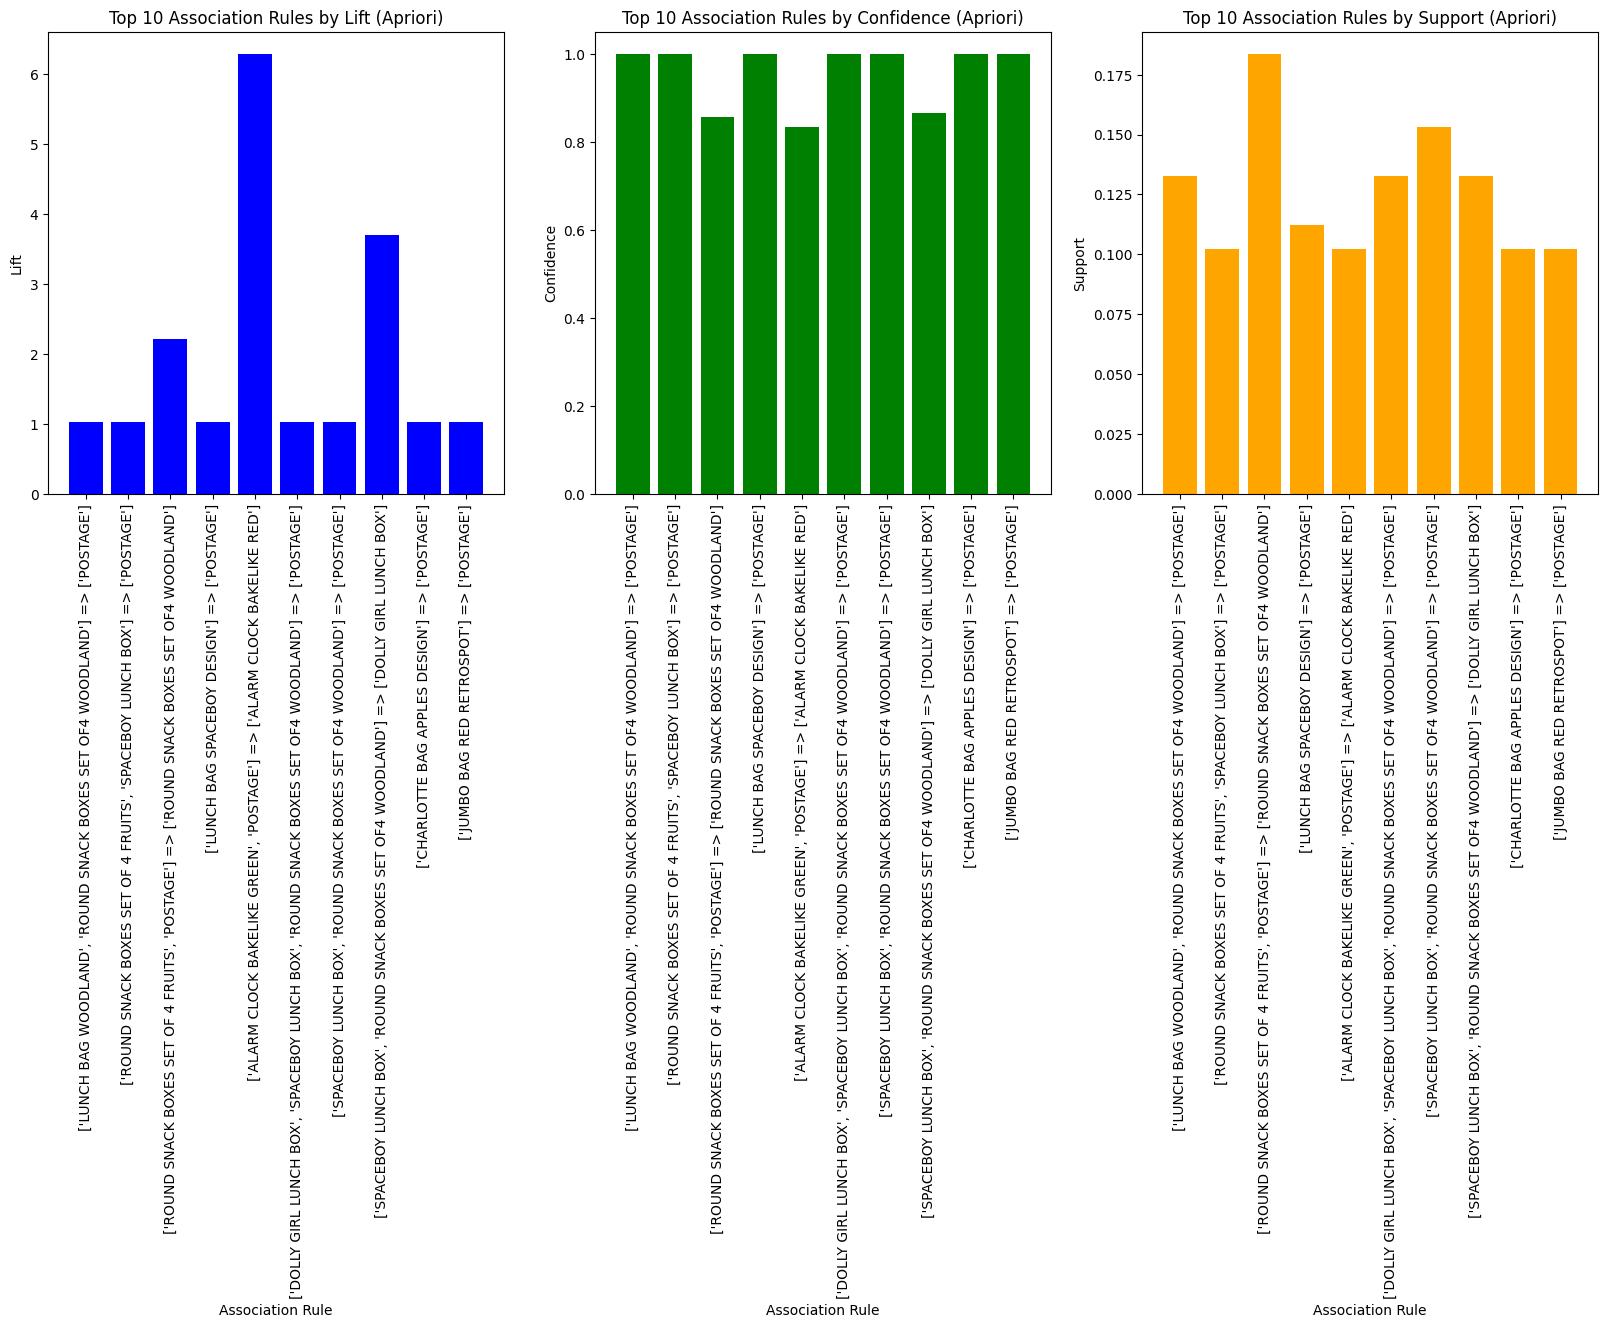

<ipython-input-55-588d518f778b>:32: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


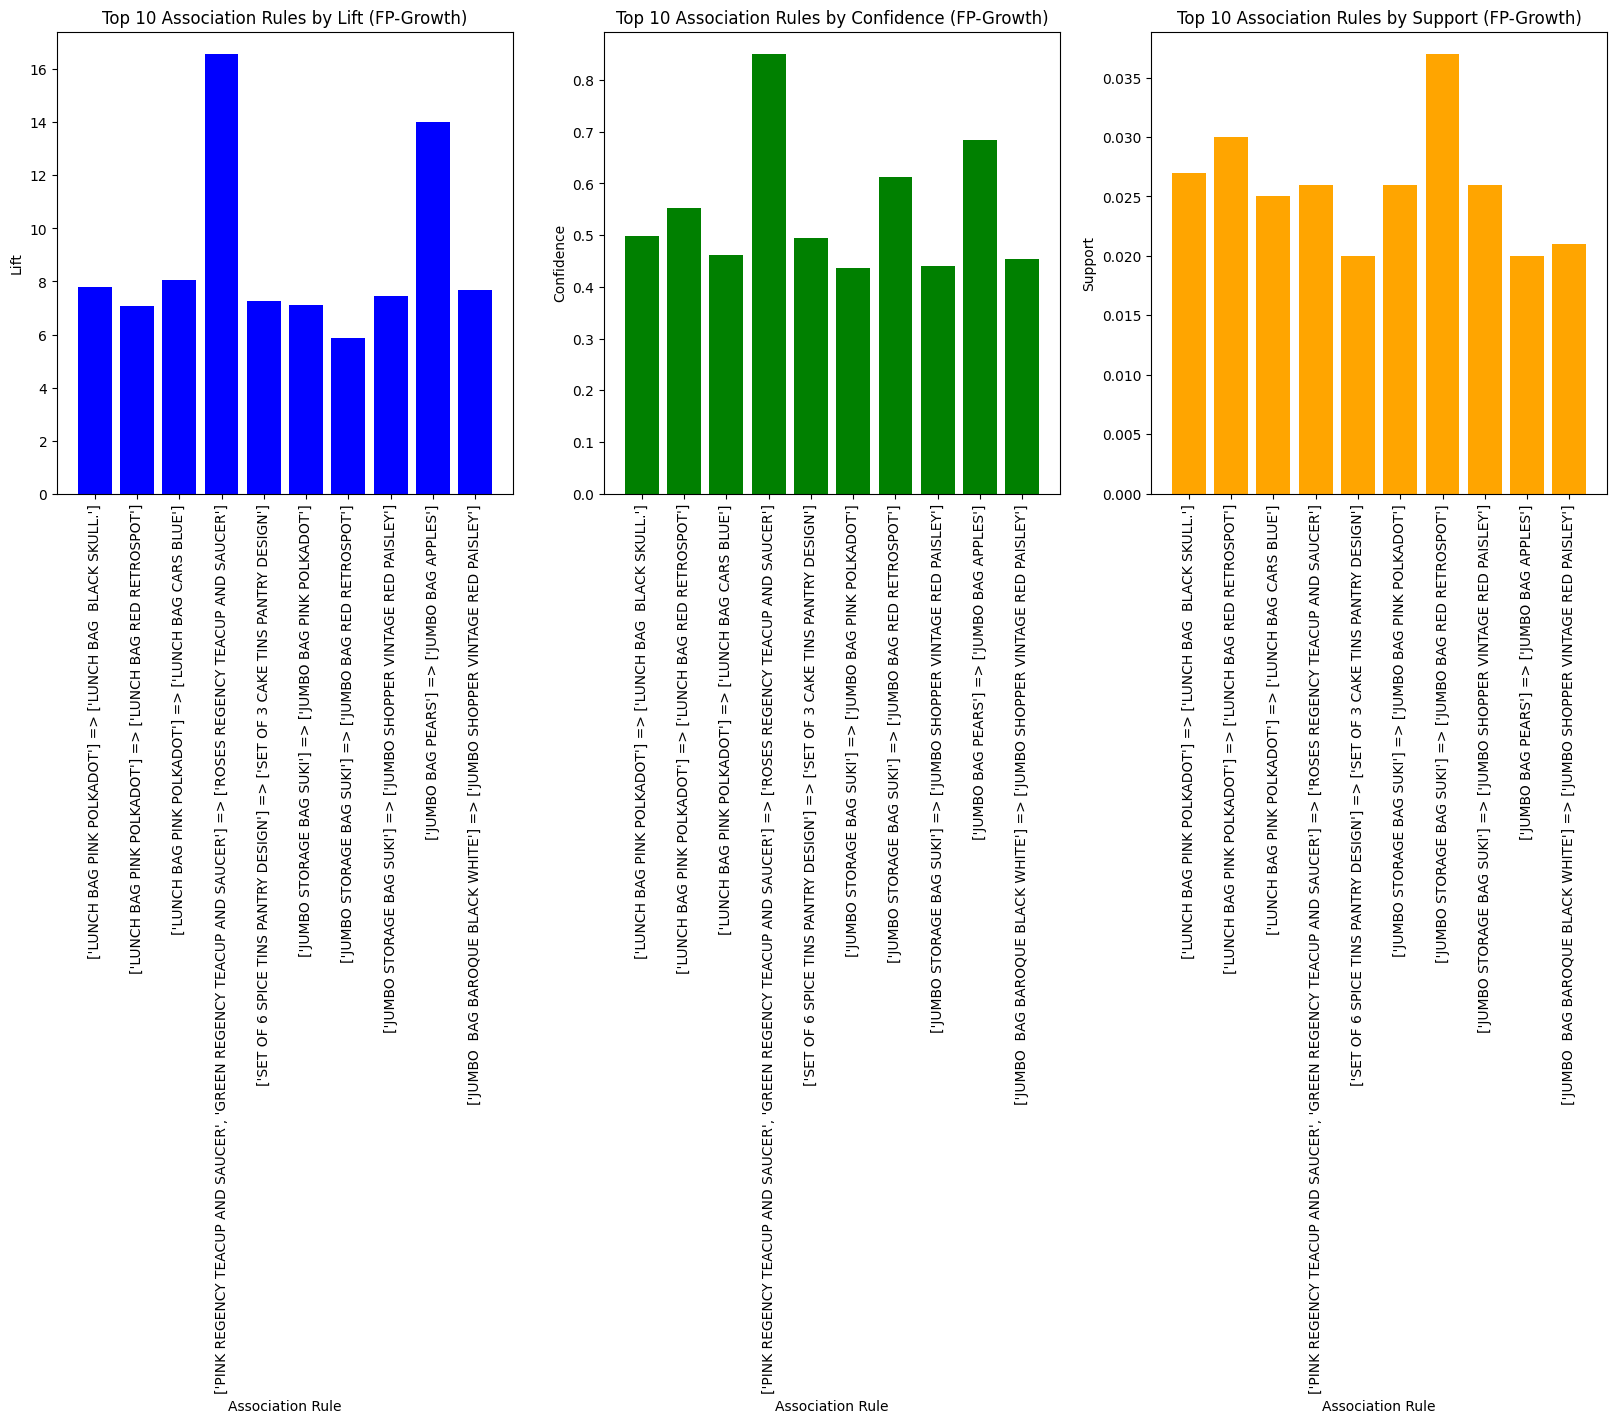

In [55]:
# Define the function to plot association rules with support
def plot_association_rules(rules_df, algorithm_name):
    top_rules = rules_df.limit(10).toPandas()  # Consider top 10 rules for visualization
    x = range(len(top_rules))

    fig, axs = plt.subplots(1, 3, figsize=(20, 6))

    # Plot for lift
    axs[0].bar(x, top_rules['lift'], color='blue')
    axs[0].set_title(f'Top 10 Association Rules by Lift ({algorithm_name})')
    axs[0].set_xlabel('Association Rule')
    axs[0].set_ylabel('Lift')
    axs[0].set_xticks(x)
    axs[0].set_xticklabels([f"{antecedent} => {consequent}" for antecedent, consequent in zip(top_rules['antecedent'], top_rules['consequent'])], rotation=90)

    # Plot for confidence
    axs[1].bar(x, top_rules['confidence'], color='green')
    axs[1].set_title(f'Top 10 Association Rules by Confidence ({algorithm_name})')
    axs[1].set_xlabel('Association Rule')
    axs[1].set_ylabel('Confidence')
    axs[1].set_xticks(x)
    axs[1].set_xticklabels([f"{antecedent} => {consequent}" for antecedent, consequent in zip(top_rules['antecedent'], top_rules['consequent'])], rotation=90)

    # Plot for support
    axs[2].bar(x, top_rules['support'], color='orange')
    axs[2].set_title(f'Top 10 Association Rules by Support ({algorithm_name})')
    axs[2].set_xlabel('Association Rule')
    axs[2].set_ylabel('Support')
    axs[2].set_xticks(x)
    axs[2].set_xticklabels([f"{antecedent} => {consequent}" for antecedent, consequent in zip(top_rules['antecedent'], top_rules['consequent'])], rotation=90)

    plt.tight_layout()
    plt.show()

# Plot association rules with support for Apriori
plot_association_rules(apriori, "Apriori")

# Plot association rules with support for FP-Growth
plot_association_rules(results, "FP-Growth")


# Result of Analysis:

By comparing the results using two methods - Apriori and FP Growth following observations are made for each characteristics:

- Lift : Association appears to be higher in FP growth than Apriori
- Confidence : appears to be more favourable in Apriori than FP **growth**
- Support : appears to be dominant in Apriori than in FP growth

### Why Apriori for Market Basket Analysis using Spark on top of FP Growth Association Rule ?

Both association rules are equally preferred, however in some scenarios Apriori Rules over FP Growth due to following reasons :

*   **Interpretability**: The if-then structure that Apriori uses to build association rules makes them simple to comprehend.
*   **Small to Medium-Sized Datasets** :  Apriori works well with datasets with a manageable number of items and transactions that fit into memory.
*   **Simplicity in Parameter Tuning** : Apriori simplifies the procedure with fewer parameters to adjust, particularly when threshold sets are guided by domain knowledge.
*   **Explicit Candidate Generation**: The methodical approach to candidate generation by Apriori offers insights into dataset relationships and algorithm behaviour.
*   **Preference for Rule Generation**: For a more detailed understanding, analysts might like Apriori's method of explicitly creating all frequent itemsets and association rules.

However, it's important to remember that FP-Growth has advantages in terms of efficiency and scalability, particularly when working with huge datasets that have high-dimensional itemsets. Various criteria, including dataset size, processing resources, interpretability requirements, and analysis aims, influence the decision between Apriori and FP-Growth.









## Future Work

*   **Visualization and Interpretation**: Develop interactive and visually appealing dashboards to present the results of the market basket analysis, allowing stakeholders to explore the association rules interactively and gain insights more intuitively.

*   **Integration with Recommendation Systems**: Integrate the association rules generated from market basket analysis into recommendation systems to provide personalized product recommendations to customers based on their purchasing history and preferences.
Experiment with collaborative filtering techniques and hybrid recommendation approaches to enhance the accuracy and relevance of product recommendations.
*   **Real-Time Analysis and Deployment**: Explore real-time market basket analysis by integrating streaming data sources and deploying the analysis pipeline in a production environment.
Implement automated model updating and retraining mechanisms to adapt to changes in customer behavior and market dynamics over time.





